(c) Juan Gomez 2019. Thanks to Universidad EAFIT for support. This material is part of the course Introduction to Finite Element Analysis

# Stress analysis with SolidsPy

## Introduction

This notebook briefly describes the steps required to conduct stress analysis over two-dimensional elastic domains using **SolidsPy**. The process involves meshing the domain with **gmsh**, a free three-dimensional finite element mesh generetor, and the generation of the required **SolidsPy** input files using available Python subroutines. 

**After completing this notebook you should be able to:**

* Identify the representation of a finite element model in the open code **SolidsPy** in terms of text files.

* Create a finite element model of a two-dimensional domain using **gmsh** and ready to be processed with **SolidsPy**.

* Create Python scripts required to convert a **gmsh** finte element model into **SolidsPy**.

**Note: To cover this notebook the user must have installed SolidsPy and the required modules as defined in the code's REPO. Similarly, files to conduct the example are available in the files folder of this REPO**

## SolidsPy

**SolidsPy** is a simple finite element code to conduct stress analysis of arbitrary two-dimensional elastic domains. The code has been created for teaching purposses by Juan Gomez and Nicolas Guarin-Zapata from the Applied Mechanics Lab at [Universidad EAFIT](http://www.eafit.edu.co/) . It has a modular structure so it can be used by simply typing an execution command from within a Python terminal or through the execution of problem dependent scripts written with **SolidsPy** own subroutines.



Currently **SolidsPy** supports an element library with the following elements: 



<center><img src="img/elelib.png" alt="files" style="width:600px"></center>

In **SolidsPy** a finite element model is represented in terms of text files defining the nodes, elements, loads and material properties. The complete description of the code, together with detailed tutorials and installation instructions is avaialable in the following [REPO.](https://github.com/AppliedMechanics-EAFIT/SolidsPy)

## Steps in the creation of a finite element model for SolidsPy

The Python code **SolidsPy** conducts stress analysis over two-dimensional (plane strain) elastic domains discretized with finite elements. The code uses, as input data, a finite element representation of the 2D solid described in terms of text files defining:

* Nodal data: Space coordinates and displacement boundary conditions for every nodal point in the model.

* Element data: Fundamental interpolation function, material properties and nodal points for each element in the mesh.

* Loads data: Load vector (defined in a cartesian reference system) and nodal data for each loaded loaded point in the model.

* Materials data: Young's modulus and Poisson's ratio for each new material appearing in the model.

The creation of a model in **SolidsPy** involves two basic steps, namely:

* (i) meshing the 2D domain

* (ii) writing the input (text) files.

In the case of complex domains resulting in a large number of elements step 1 is conducted with third party software. Here we will use [gmsh](http://gmsh.info/) to create finite element meshes. On the other hand, step 2 involving the process of writing the input files for **SolidsPy** is performed using subroutines available in the Python module [meshio](https://github.com/nschloe/meshio). The complete process is schematically described in the figure below.

<center><img src="img/steps.png" alt="files" style="width:600px"></center>

The first step, involving the creation of a model in **gmsh** is not covered in this notebook, however the following video presents a summary of these steps for a simple model. 

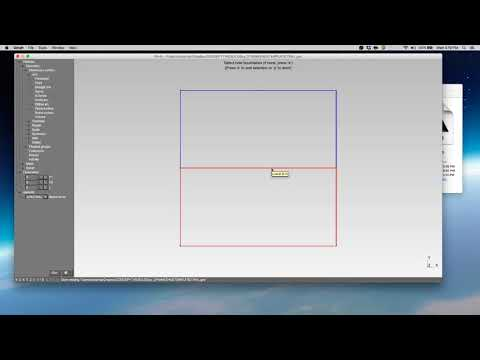

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('ibeIKaSYG2U')

## Problem definition.

Once the model is created with **gmsh** it must be converted into **SolidsPy** input files. This second step is conducted with Python subroutines coded in the module **meshio** which can interpret all the parts in a **gmsh** model and convert them into Python dictionaries. These dictionaries can then be processed in standrd Python based scripts. This process is described next with reference to a simple elasticty problem.

The problem to be solved consists in finding the stress tensor over a bi-material plate (under plane strain conditions) loaded at the top surface by a uniform load of intensity W. Each material is characterized by its Poisson’s ratio and Young modulus. The bottom surface is not allowed to displace along the vertical direction while the lateral surfaces are not allowed to experience horizontal displacements as indicated by the roller supports.

<center><img src="img/biplate.png" alt="files" style="width:500px"></center>

## Model definition.

In **gmsh** a model is defined through the creation and combination of **geometric objects** of increasing hierarchy. In the case of two-dimensional domains these are summarized like:

* Points.
* Lines: resulting from the combination of points.
* Plane surafces (or line loops): resulting from the combination of several lines.

This process is ilustrated in the following figure.

<center><img src="img/geometric.png" alt="files" style="width:500px"></center>

To facilite the subsequent interpretation of the different parts of the model in a finte element analysis **gmsh** allows the creation of groups of these **geometric objects** into **physical objects**. For instance, these **physical objects** are useful in the definition of loads over specific lines, on assignaning material properties to the different parts of the region and in the defintion of displacement boundary conditions along specific groups of nodes. The followong figure shows the **physical objects** for the current example.

<center><img src="img/phys_OBJ.png" alt="files" style="width:600px"></center>

Note that each such physical object is named by an integer number. In this case physical line **500** defines the top surface of the model where the uniform load is to be applied; physical line **300** corresponds to the lateral surfaces where the horizontal displacement component are resrained; physical line **400** is the bottom surface with restrained vertical displacements and finally physical surfaces **100** and **200** define respectively regions of the model whose material properties are either 1 or 2.

## Converting the gmsh model into SolidsPy text files.

Once the mesh is created the information of nodes, lines, elements and other geometric entities would be associated to the different physical objects facilitating its interpretation by external codes.

In **SolidsPy** a finite element model is described in terms of 4 text files, namely: **nodes.txt**, **eles.txt**, **loads.txt** and **mater.txt**. The creation of these files out of the **gmsh** model is schematized in the following figure.

**Note: The structure of the input files used by SolidsPy is described for a 4-elements simple [square](https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/docs/tutorials/square_example.rst) problem.**

<center><img src="img/conversion.png" alt="files" style="width:700px"></center>

To make this conversion from **gmsh** to **SolidsPy** the user needs to create a problem dependent script based on 4 subroutines available on the pre-processing module from **SolidsPy**. These subroutines interpret the **gmsh** model using the identifiers for the different **phyiscal objects**. The subroutines are summarized like:

* **node_writer()**: The function returns the numpy array **nodes_array[]** ready to be written into the file **nodes.txt** of **SolidsPy**.

* **boundary_conditions()**: Handles each physical line where displacement boundary conditions are imposed.

* **loading()**: The subroutine uses the load magnitudes  along the x and y direction defined by the parameters P_x and P_y and divides the resultant force by the number of nodes pertaining to the **physical line**.

* **ele_writer()**: It is used to write the text file with the element data. The subroutine must be used as many times as physical surfaces there are in the model in order to assign different material properties or different element types.

In [2]:
%matplotlib inline        
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import solidspy.preprocesor as msh
import solidspy.assemutil as ass
import solidspy.postprocesor as pos
import solidspy.solutil as sol
import meshio

**readin()** is also avaialble within **SolidsPy** but here we have added a modified version to upload the input files from the **files** folder in this REPO. The specific files to be read are **Mnodes.txt**, **Meles.txt**, **Mloads.txt** and **Mmater.txt**

In [3]:
def readin():
    nodes    = np.loadtxt('files/' + 'Mnodes.txt', ndmin=2)
    mats     = np.loadtxt('files/' + 'Mmater.txt', ndmin=2)
    elements = np.loadtxt('files/' + 'Meles.txt', ndmin=2, dtype=np.int)
    loads    = np.loadtxt('files/' + 'Mloads.txt', ndmin=2)

    return nodes, mats, elements, loads

### Meshing script

In the following block of code we write the meshing script for the bi-material plate example. A graphical description of the script is also given in the figure. The script uses the **gmsh** model given by the file **template.msh** available in the **files** folder of the REPO and writes the text files **Mnodes.txt**, **Meles.txt** and **Mloads.txt** to that same folder.

**Question:**

**Using the figure below, which shows a graphical description of the meshing script used to generate the text files corresponding to the bi-material plate model add comments to each one of the relevant commands in the script.**

In [4]:
#points, cells, point_data, cell_data, field_data = meshio.read("files/template.msh")
mesh = meshio.read("files/template.msh")
points = mesh.points
cells = mesh.cells
point_data = mesh.point_data
cell_data = mesh.cell_data
nodes_array     = msh.node_writer(points , point_data)
nf , els1_array = msh.ele_writer(cells , cell_data , "triangle" , 100 , 3 , 0 , 0)
nini = nf
nf , els2_array = msh.ele_writer(cells , cell_data , "triangle" , 200 , 3 , 1 , nini)
els_array =np.append(els1_array , els2_array , axis = 0)
#
nodes_array = msh.boundary_conditions(cells , cell_data , 300 , nodes_array , -1 , 0)
nodes_array = msh.boundary_conditions(cells , cell_data , 400 , nodes_array , 0 , -1)
cargas      = msh.loading(cells , cell_data , 500 , 0.0 , -2.0)
np.savetxt("files/Meles.txt" , els_array   , fmt="%d")
np.savetxt("files/Mloads.txt", cargas, fmt=("%d", "%.6f", "%.6f"))
np.savetxt("files/Mnodes.txt", nodes_array , fmt=("%d", "%.4f", "%.4f", "%d", "%d"))

<center><img src="img/grafdescr.png" alt="files" style="width:700px"></center>

## Executing the analysis

Once the input files are written in the **files** folder the analaysis can be executed. Here we do this following a step-by-step process where we compute the assembly operator, use it to assemble the global system of equations and solve the system to complete the solution. Alternatively the analysis can also be performed using a single call to the execution subroutine as descripbed in the [REPO.](https://github.com/AppliedMechanics-EAFIT/SolidsPy)

C:\Users\AX201 GMRS\Anaconda3\lib\site-packages\solidspy\postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


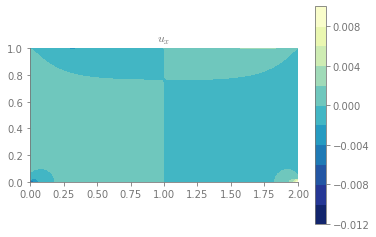

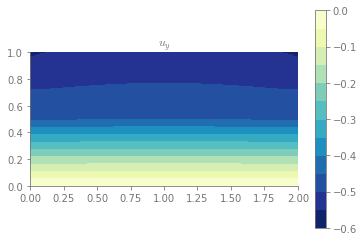

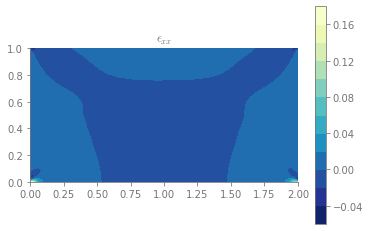

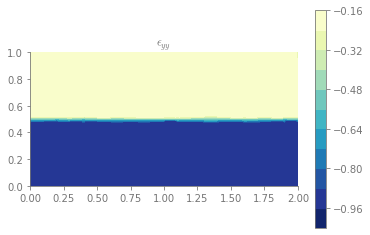

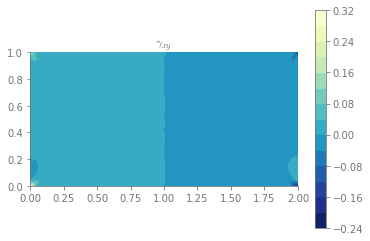

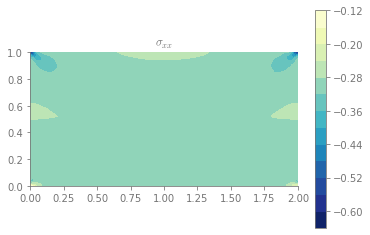

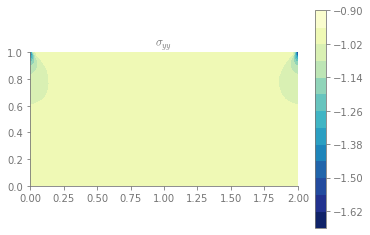

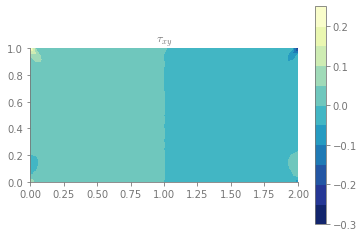

In [5]:
nodes, mats, elements, loads = readin()
DME , IBC , neq = ass.DME(nodes, elements)
KG = ass.assembler(elements, mats, nodes, neq, DME)
RHSG = ass.loadasem(loads, IBC, neq)
UG = sol.static_sol(KG, RHSG)
UC = pos.complete_disp(IBC, nodes, UG)
E_nodes, S_nodes = pos.strain_nodes(nodes , elements, mats, UC)
pos.fields_plot(elements, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes)

### Glossary of terms

**gmsh:** An external and free finite element mesher for two and three-dimensional computational domains.

**Geometric objects:** Hierarchichal geometric entities used in the construction of computational domains within **gmsh**.

**Physical objects:** Specif groups of geometric objects defined within **gmsh** and used to facilitate subsequent finite element operations.

**meshio:** A set of Python subroutines to perform reading/writing operations between several mesh formats including **gmesh.**

**Meshing script:** Problem dependent Python script used to translate a **gmsh** model into a **SolidsPy** model and built in terms of **messhio** functions.

## Class activity.

Repeat the stress analysis for the bi-material plate but now add a third material layer. Start from the file **template.geo** available from the files folder in this Repo and containing the initial geometry.

### References

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

In [6]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()